最优策略描述: 不检测零配件 1，不检测零配件 2，不检测零配件 3，不检测零配件 4，不检测零配件 5，不检测零配件 6，不检测零配件 7，不检测零配件 8，不检测半成品 1，不检测半成品 2，不检测半成品 3，不检测成品，不拆解不合格成品
最优总成本: 102.15
最优次品率: 0.15


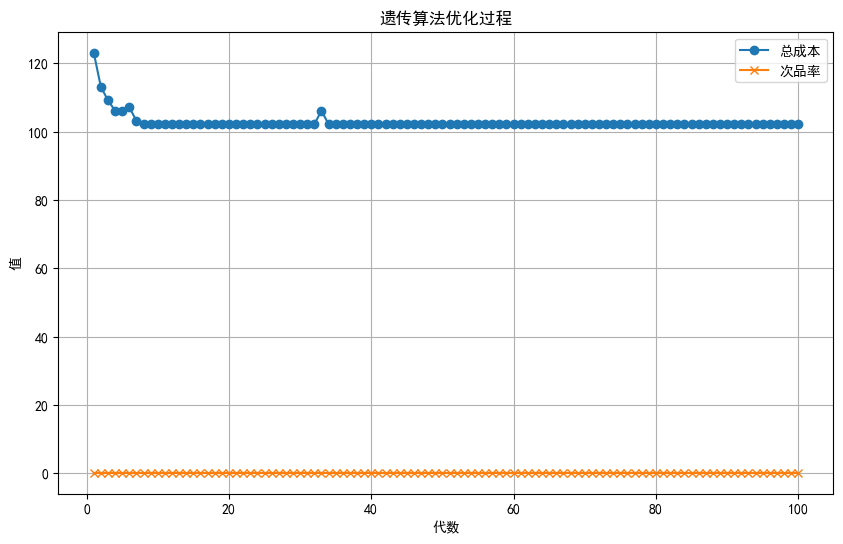

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.sans-serif'] = ['SimHei']
rcParams['axes.unicode_minus'] = False

# 贝叶斯更新函数
def bayesian_update(k, n, alpha_prior=1, beta_prior=1):
    alpha_post = alpha_prior + k
    beta_post = beta_prior + (n - k)
    return alpha_post, beta_post

def expected_defective_rate(alpha_post, beta_post):
    return alpha_post / (alpha_post + beta_post)

# 从Excel文件中读取更新的次品率
df_updated = pd.read_excel('问题3零配件半成品成品更新次品率.xlsx')
updated_defective_rates = df_updated.set_index('项目')['更新次品率'].to_dict()

# 零配件信息
components = {
    '零配件1': {'次品率': updated_defective_rates.get('零配件1', 0.1), '购买单价': 2, '检测成本': 1},
    '零配件2': {'次品率': updated_defective_rates.get('零配件2', 0.1), '购买单价': 8, '检测成本': 1},
    '零配件3': {'次品率': updated_defective_rates.get('零配件3', 0.1), '购买单价': 12, '检测成本': 2},
    '零配件4': {'次品率': updated_defective_rates.get('零配件4', 0.1), '购买单价': 2, '检测成本': 1},
    '零配件5': {'次品率': updated_defective_rates.get('零配件5', 0.1), '购买单价': 8, '检测成本': 1},
    '零配件6': {'次品率': updated_defective_rates.get('零配件6', 0.1), '购买单价': 12, '检测成本': 2},
    '零配件7': {'次品率': updated_defective_rates.get('零配件7', 0.1), '购买单价': 8, '检测成本': 1},
    '零配件8': {'次品率': updated_defective_rates.get('零配件8', 0.1), '购买单价': 12, '检测成本': 2},
}

# 半成品信息
semi_products = {
    '半成品1': {'次品率': updated_defective_rates.get('半成品1', 0.1), '装配成本': 8, '检测成本': 4, '拆解费用': 6},
    '半成品2': {'次品率': updated_defective_rates.get('半成品2', 0.1), '装配成本': 8, '检测成本': 4, '拆解费用': 6},
    '半成品3': {'次品率': updated_defective_rates.get('半成品3', 0.1), '装配成本': 8, '检测成本': 4, '拆解费用': 6},
}

# 成品信息
final_product = {
    '成品': {'次品率': updated_defective_rates.get('成品', 0.1), '装配成本': 8, '检测成本': 6, '拆解费用': 10, '售价': 200, '调换损失': 40}
}

# 计算总成本（次品率不受检测影响）
def calculate_expected_cost(components, semi_products, final_product, detect_components, detect_semi, detect_final, dismantle):
    total_cost = 0

    # 计算零配件成本
    for i, (comp_name, comp_data) in enumerate(components.items()):
        cost = comp_data['购买单价']
        if detect_components[i]:
            cost += comp_data['检测成本']  # 增加检测成本
        total_cost += cost

    # 计算半成品成本
    for i, (semi_name, semi_data) in enumerate(semi_products.items()):
        cost = semi_data['装配成本']
        if detect_semi[i]:
            cost += semi_data['检测成本']  # 增加检测成本
        total_cost += cost

    # 计算成品成本
    final_cost = final_product['成品']['装配成本']
    if detect_final:
        final_cost += final_product['成品']['检测成本']  # 增加检测成本
    total_cost += final_cost

    # 换货损失，不受检测影响的成品次品率
    exchange_loss = final_product['成品']['调换损失'] * final_product['成品']['次品率']
    total_cost += exchange_loss

    # 拆解费用
    if dismantle:
        total_cost += final_product['成品']['拆解费用']

    return total_cost, final_product['成品']['次品率']

# 生成策略描述
def generate_strategy_description(detect_components, detect_semi, detect_final, dismantle):
    description = ""
    for i, detect in enumerate(detect_components):
        description += f"检测零配件 {i + 1}，" if detect else f"不检测零配件 {i + 1}，"
    for i, detect in enumerate(detect_semi):
        description += f"检测半成品 {i + 1}，" if detect else f"不检测半成品 {i + 1}，"
    if detect_final:
        description += "检测成品，"
    else:
        description += "不检测成品，"
    if dismantle:
        description += "拆解不合格成品"
    else:
        description += "不拆解不合格成品"
    return description

# 适应度函数
def fitness_function(chromosome, components, semi_products, final_product):
    detect_components = chromosome[:8]
    detect_semi = chromosome[8:11]
    detect_final = chromosome[11]
    dismantle = chromosome[12]

    cost, defective_rate = calculate_expected_cost(components, semi_products, final_product, detect_components,
                                                   detect_semi, detect_final, dismantle)
    return cost, defective_rate

# 初始化种群
def initialize_population(population_size, num_genes):
    return np.random.randint(2, size=(population_size, num_genes))

# 选择父代
def selection(population, fitness_values, num_parents):
    parents = np.empty((num_parents, population.shape[1]), dtype=int)
    for i in range(num_parents):
        min_fitness_idx = np.argmin(fitness_values)
        parents[i, :] = population[min_fitness_idx, :]
        fitness_values[min_fitness_idx] = np.inf
    return parents

# 交叉
def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size, dtype=int)
    crossover_point = np.uint8(offspring_size[1] / 2)

    for k in range(offspring_size[0]):
        parent1_idx = k % parents.shape[0]
        parent2_idx = (k + 1) % parents.shape[0]
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

# 变异
def mutation(offspring_crossover, mutation_rate):
    for idx in range(offspring_crossover.shape[0]):
        if np.random.rand() < mutation_rate:
            random_gene_idx = np.random.randint(offspring_crossover.shape[1])
            offspring_crossover[idx, random_gene_idx] = 1 - offspring_crossover[idx, random_gene_idx]
    return offspring_crossover

# 遗传算法主函数
def genetic_algorithm(components, semi_products, final_product, population_size=1000, num_generations=100, mutation_rate=0.01):
    num_genes = 13
    population = initialize_population(population_size, num_genes)
    results = []

    for generation in range(num_generations):
        fitness_values = np.array([fitness_function(chromosome, components, semi_products, final_product)[0] for chromosome in population])
        parents = selection(population, fitness_values, population_size // 2)
        offspring_crossover = crossover(parents, offspring_size=(population_size - parents.shape[0], num_genes))
        offspring_mutation = mutation(offspring_crossover, mutation_rate)
        population[0:parents.shape[0], :] = parents
        population[parents.shape[0]:, :] = offspring_mutation

        # 记录每一代的最优策略
        best_chromosome = population[np.argmin(fitness_values)]
        best_cost, best_defective_rate = fitness_function(best_chromosome, components, semi_products, final_product)
        best_strategy_description = generate_strategy_description(best_chromosome[:8], best_chromosome[8:11], best_chromosome[11], best_chromosome[12])
        results.append([generation + 1, best_strategy_description, best_cost, best_defective_rate])

    # 找到最优策略
    best_chromosome = population[np.argmin(fitness_values)]
    best_cost, best_defective_rate = fitness_function(best_chromosome, components, semi_products, final_product)
    best_strategy_description = generate_strategy_description(best_chromosome[:8], best_chromosome[8:11], best_chromosome[11], best_chromosome[12])
    
    print(f"最优策略描述: {best_strategy_description}")
    print(f"最优总成本: {best_cost:.2f}")
    print(f"最优次品率: {best_defective_rate:.2f}")

    # 保存优化结果到Excel
    df_results = pd.DataFrame(results, columns=['代数', '策略描述', '总成本', '次品率'])
    df_results.to_excel('遗传算法优化结果.xlsx', index=False)

    # 可视化结果
    plt.figure(figsize=(10, 6))
    plt.plot(df_results['代数'], df_results['总成本'], marker='o', label='总成本')
    plt.plot(df_results['代数'], df_results['次品率'], marker='x', label='次品率')
    plt.xlabel('代数')
    plt.ylabel('值')
    plt.title('遗传算法优化过程')
    plt.legend()
    plt.grid(True)
    plt.show()

# 运行遗传算法
genetic_algorithm(components, semi_products, final_product)
